Base shape: (1000000, 960)
Learn shape: (500000, 960)
Query shape: (1000, 960)
Groundtruth shape: (1000, 100)
IVF 생성 완료
HNSW 생성 완료


IVF Search: 100%|██████████| 8/8 [06:24<00:00, 48.02s/it]


IVF 검색 완료


HNSW Search: 100%|██████████| 8/8 [00:20<00:00,  2.53s/it]


HNSW 검색 완료


PQ Search: 100%|██████████| 8/8 [16:21<00:00, 122.73s/it]


PQ 검색 완료


LSH Search: 100%|██████████| 4/4 [10:53<00:00, 163.28s/it]


LSH 검색 완료


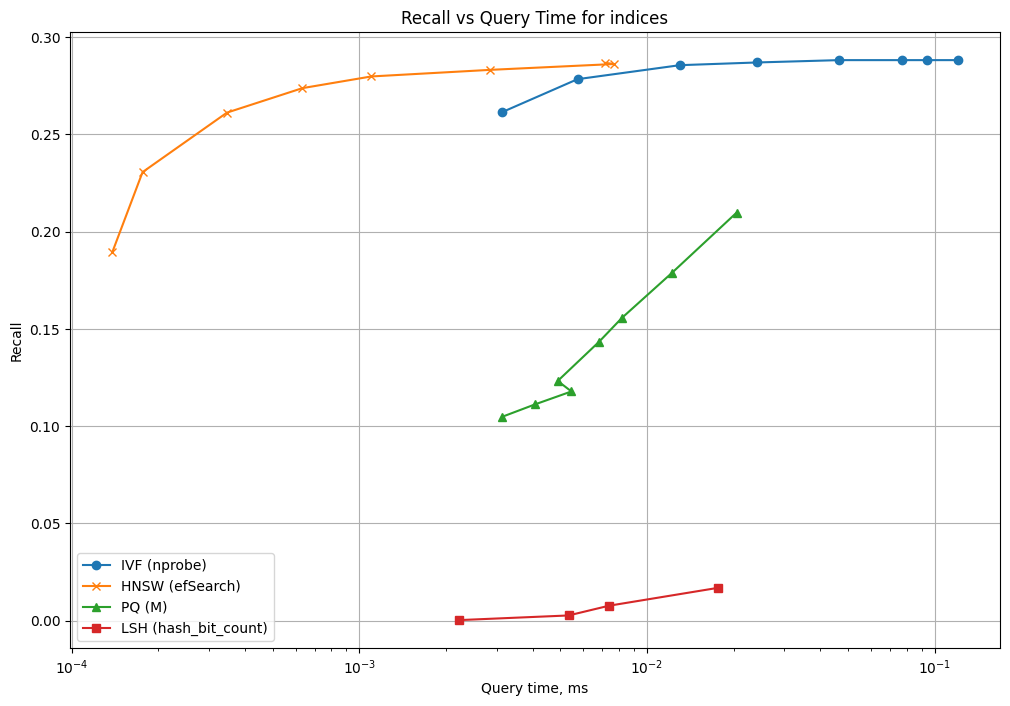

In [1]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

def read_fvecs(filename):
    with open(filename, 'rb') as f:
        # 읽기
        data = np.fromfile(f, dtype='int32')
        # 첫 번째 값을 차원으로 사용
        dim = data[0]
        # 데이터 변환 및 리턴
        return data.reshape(-1, dim + 1)[:, 1:].astype('float32')

def read_ivecs(filename):
    with open(filename, 'rb') as f:
        # 읽기
        data = np.fromfile(f, dtype='int32')
        # 첫 번째 값을 차원으로 사용
        dim = data[0]
        # 데이터 변환 및 리턴
        return data.reshape(-1, dim + 1)[:, 1:]

# 파일 경로 설정
base_path = '/data/matmang/gist/gist_base.fvecs'
learn_path = '/data/matmang/gist/gist_learn.fvecs'
query_path = '/data/matmang/gist/gist_query.fvecs'
groundtruth_path = '/data/matmang/gist/gist_groundtruth.ivecs'

# 파일 읽기
gist_base = read_fvecs(base_path)
gist_learn = read_fvecs(learn_path)
gist_query = read_fvecs(query_path)
gist_groundtruth = read_ivecs(groundtruth_path)

print(f'Base shape: {gist_base.shape}')
print(f'Learn shape: {gist_learn.shape}')
print(f'Query shape: {gist_query.shape}')
print(f'Groundtruth shape: {gist_groundtruth.shape}')

# 차원 수
dim = gist_base.shape[1]

# FlatL2 인덱스 생성 및 학습
# index_flat = faiss.IndexFlatL2(dim)
# index_flat.add(gist_base)

# IVF 인덱스 생성 및 학습
nlist = 1000  # Number of clusters
quantizer = faiss.IndexFlatL2(dim)
index_ivf = faiss.IndexIVFFlat(quantizer, dim, nlist)
index_ivf.train(gist_learn)
index_ivf.add(gist_base)

print("IVF 생성 완료")

# HNSW 인덱스 생성 및 학습
index_hnsw = faiss.IndexHNSWFlat(dim, 16)
index_hnsw.hnsw.efConstruction = 100
index_hnsw.add(gist_base)

print("HNSW 생성 완료")

# index_pq = faiss.IndexPQ(dim, 2, 8)
# index_pq.train(gist_learn)
# index_pq.add(gist_base)

# print("PQ 생성 완료")

# index_lsh = faiss.IndexLSH(dim, 2)
# index_lsh.train(gist_learn)
# index_lsh.add(gist_base)

# print("LSH 생성 완료")

def search_and_measure(index, queries, groundtruth, k=5):
    start_time = time.time()
    distances, indices = index.search(queries, k)
    query_time = time.time() - start_time
    
    recall = []
    for i, neighbors in enumerate(tqdm(indices, desc="Search")):
        gt = set(groundtruth[i][:k])
        retrieved = set(neighbors)
        correct = len(gt & retrieved)
        recall.append(correct / k)
    
    avg_recall = np.mean(recall)
    avg_query_time = query_time / len(queries)
    
    return avg_recall, avg_query_time

# IVF의 nprobe 값 변경에 따른 성능 측정
nprobe_values = [10, 20, 50, 100, 200, 300, 400, 500]
ivf_results = []

for nprobe in tqdm(nprobe_values, desc="IVF Search"):
    index_ivf.nprobe = nprobe
    recall, query_time = search_and_measure(index_ivf, gist_query, gist_groundtruth, k=5)
    ivf_results.append((recall, query_time))

print("IVF 검색 완료")

# HNSW의 efSearch 값 변경에 따른 성능 측정
efSearch_values = [10, 20, 50, 100, 200, 500, 1000, 2000]
hnsw_results = []

for efSearch in tqdm(efSearch_values, desc="HNSW Search"):
    index_hnsw.hnsw.efSearch = efSearch
    recall, query_time = search_and_measure(index_hnsw, gist_query, gist_groundtruth, k=5)
    hnsw_results.append((recall, query_time))

print("HNSW 검색 완료")

# PQ의 M 값 변경에 따른 성능 측정
M_values = [40, 48, 60, 64, 80, 96, 120, 160]
pq_results = []

for M in tqdm(M_values, desc="PQ Search"):
    index_pq = faiss.IndexPQ(dim, M, 8)
    index_pq.train(gist_learn)
    index_pq.add(gist_base)
    recall, query_time = search_and_measure(index_pq, gist_query, gist_groundtruth, k=5)
    pq_results.append((recall, query_time))

print("PQ 검색 완료")

# # LSH의 hash_bit_count 값 변경에 따른 성능 측정
hash_bit_count_values = [1, 2, 4, 8]
lsh_results = []

for hash_bit_count in tqdm(hash_bit_count_values, desc="LSH Search"):
    index_lsh = faiss.IndexLSH(dim, hash_bit_count * dim)
    index_lsh.train(gist_learn)
    index_lsh.add(gist_base)
    recall, query_time = search_and_measure(index_lsh, gist_query, gist_groundtruth, k=5)
    lsh_results.append((recall, query_time))

print("LSH 검색 완료")

# Recall 및 Query Time 시각화
plt.figure(figsize=(12, 8))

# IVF 결과 시각화
ivf_recall_values = [result[0] for result in ivf_results]
ivf_query_time_values = [result[1] for result in ivf_results]
plt.plot(ivf_query_time_values, ivf_recall_values, label='IVF (nprobe)', marker='o')

# HNSW 결과 시각화
hnsw_recall_values = [result[0] for result in hnsw_results]
hnsw_query_time_values = [result[1] for result in hnsw_results]
plt.plot(hnsw_query_time_values, hnsw_recall_values, label='HNSW (efSearch)', marker='x')

# PQ 결과 시각화
pq_recall_values = [result[0] for result in pq_results]
pq_query_time_values = [result[1] for result in pq_results]
plt.plot(pq_query_time_values, pq_recall_values, label='PQ (M)', marker='^')

# LSH 결과 시각화
lsh_recall_values = [result[0] for result in lsh_results]
lsh_query_time_values = [result[1] for result in lsh_results]
plt.plot(lsh_query_time_values, lsh_recall_values, label='LSH (hash_bit_count)', marker='s')

plt.xscale('log')
plt.xlabel('Query time, ms')
plt.ylabel('Recall')
plt.title('Recall vs Query Time for indices')
plt.legend()
plt.grid(True)
plt.savefig('GIST1M_temp.png', format='png')
plt.show()